# First pass of L1, L2 constrained regression on FMRI

I"m analyzing the `ds114` dataset from OpenFMRI:

* https://openfmri.org/dataset/ds000114

I applied standard pre-processing with SPM using nipype - see: https://github.com/matthew-brett/consden/blob/master/nipype_ds114_t2.py

In summary:

* Dropped first 4 (dummy) volumes;
* Slice time correction;
* Motion correction;
* Coregister structural to mean functional;
* SPM segment / normalize of coregistered structural;
* Reslice of (slice-time, motion corrected) EPIs to template space.

## The study

There were multiple tasks in this study, but I have chosen to analyze just one, a verbal fluency block design.

The task was a block design with 10 seconds rest followed by 7 repeats of (30 seconds when the subject thought of verbs followed by 30 seconds rest).

This is `task002` in the OpenFMRI naming scheme for this dataset.

## The designs

There are two designs:
    
* standard - a standard FMRI design matrix, with a convolved HRF regressor, 6 columns of motion parameters and 8 columns from a DCT basis set.  Call this matrix $X_s$.
* extended - the standard model extended with multiple noise regressors.  Call the matrix of noise regressors $X_n$.  The extended model is $[ X_s X_n ]$.

### The standard design

In [1]:
from ds114 import gen_models, TR, SUBJECTS
# Get the run model for the first subject, first run
run_model = next(gen_models([SUBJECTS[0]]))
run_model

I would normally load the data to find the (remaining) number of TRs.  I would also load the motion parameter text files from the SPM analysis.  But, these aren't stored in the repository, so I'll make up some values:

In [2]:
import numpy as np

n_trs = 169
motion_regressors = np.random.normal(size=(n_trs, 6))

The standard design matrix (see https://github.com/matthew-brett/consden/blob/master/consden_ds114.py#L68):

In [3]:
from consden.nutils import openfmri2nipy
from consden.designs import compile_design

DCT_ORDER = 8
N_DUMMIES = 4

vol0_start_time = N_DUMMIES * TR
vol_times = vol0_start_time + np.arange(n_trs) * TR
cond_no, ons_dur_amp = run_model.conditions[0]
block_spec = openfmri2nipy(ons_dur_amp)
X_s, cons = compile_design(vol_times,
                          [('motor', block_spec)],
                          extra_cols=motion_regressors,
                          dct_order=DCT_ORDER)

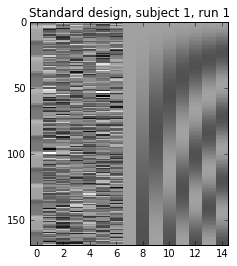

In [4]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['image.cmap'] = 'gray'
plt.rcParams['image.interpolation'] = 'nearest'
plt.imshow(X_s, aspect=0.1)
plt.title("Standard design, subject 1, run 1")

### The noise design

The noise design has three components (sets of columns):

* Delta component $X_d$ : `(n_trs, n_trs)` shape matrix modeling a jump in signal for a single scan;
* Step component $X_p$ : `(n_trs, n_trs-3)` shape matrix modeling a step change in signal at each scan;
* T1 decay component $X_t$ : `(n_trs, n_trs-1)` shape component modeling a signal jump convolved with T1 MRI signal decay.

The (-3, -1) above are after removing colinear columns - for example the step function at scan 1 is colinear with the delta at scan 0.

The noise design is $[ X_d X_p X_t ]$.

$X_t$ models "spin-history" movement effects.  These occur when the subject moves.  The movement causes slices to have be stimulated at an earlier or later time relative to the previous scan.  This difference in stimulation time causes a difference in the sensitivity of the water molecules to MRI (RF) stimulation.   The effect lasts for a few scans, depending on the "T1" or "lattice relaxation" time of the tissue.

From Wikipedia: https://en.wikipedia.org/wiki/Spin%E2%80%93lattice_relaxation

$$
M_z(t) = M_{z,\mathrm{eq}} - \left [ M_{z,\mathrm{eq}} - M_{z}(0) \right ] e^{-t/T_1}
$$

In [5]:
from consden.designs import build_confounds

# T1 for gray matter at 1.5T, in seconds.
# https://en.wikipedia.org/wiki/Relaxation_(NMR)#T1
T1_GRAY_1p5T = 0.920

X_n = build_confounds(X_s, vol_times, T1_GRAY_1p5T)
n_noise = X_n.shape[1]
n_noise

503

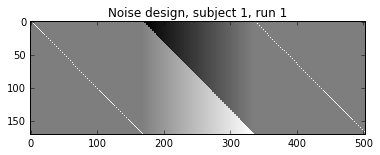

In [6]:
plt.imshow(X_n)
plt.title("Noise design, subject 1, run 1")

I've subtracted the mean of each column:

In [7]:
np.allclose(np.mean(X_n, axis=0), 0)

True

The T1 decay is relatively fast compared to the TR, so the T1 decay columns are very similar to the delta columns:

In [8]:
np.corrcoef(X_n[:, 0], X_n[:, 169 + 166])

array([[ 1.        ,  0.99781661],
       [ 0.99781661,  1.        ]])

## The models

There are two models.  Both fit the data $Y$ where $Y$ is shape ``(n_trs, n_voxels)`` and `n_voxels` is the number of voxels within a mask identifying within-brain voxels.

* "unfixed" - the standard design $X_s$ fitted by OLS: $Y = X_s B + E$;
* "fixed" - the extended design $[X_s X_n]$ where the parameters $B_n$ corresponding to $X_n$ are penalized with with an L1, L2 penalty:

$$
\text{minimize}_{B_s, B_n} \frac{1}{2} \|Y - X_s B_s - X_n B_n\|^2_F + \lambda \sum_{g \in G} w_g \|B_n[g]\|_2
$$

I solved this as you (JT) suggested by orthogonalizing $Y, X_n$ with respect to $X_s$, and deriving the $B_s$ fit.  See: https://github.com/matthew-brett/consden/blob/master/consden/designs.py `solve_with_confounds`.  Here's the relevant code with some random data.

In [9]:
import numpy.linalg as npl
import regreg.api as rr

n_voxels = 1000
Y = np.random.normal(size=(n_trs, n_voxels))

X_s_pinv = npl.pinv(X_s)
# Projector onto space of experimental design
P_s = np.dot(X_s, X_s_pinv)
# Residual-forming matrix
R_s = np.eye(n_trs) - P_s
# Residuals of data w.r.t design
Y_s_resid = np.dot(R_s, Y)
# X matrix for confounds should be residualized w.r.t. design as well.
X_n_s_resid = np.dot(R_s, X_n)

# Build regreg model
loss_resid = rr.squared_error(X_n_s_resid, Y_s_resid)
loss_resid.shape = (n_noise, n_voxels)
penalty = rr.l1_l2(loss_resid.shape, lagrange=1.)

# Straight copy of langrange calculation from example notebook
dual_penalty = penalty.conjugate
lam_max = dual_penalty.seminorm(
        loss_resid.smooth_objective(np.zeros(loss_resid.shape), 'grad'),
        lagrange=1)
penalty.lagrange = 0.9 * lam_max
problem_resid = rr.simple_problem(loss_resid, penalty)

# Parameters for residualized confounds applying l1, l2 norm
B_n = problem_resid.solve(min_its=200, tol=1.e-12)
# Reconstructing estimates for experimental design
B_s = np.dot(X_s_pinv, Y - np.dot(X_n, B_n))

## Fixed and unfixed parameter volumes

I ran the standard model and the extended model for each subject and each run of ``ds114`` ``task002``.  This gives (10 subjects, 2 runs per subject) 20 "unfixed" (standard) parameter matrices and 20 "fixed" (extended) parameter matrices.

See: https://github.com/matthew-brett/consden/blob/master/consden_ds114.py

The only parameter of experimental interest is the HRF convolved block regressor which is the first column in $X_s$ and $[X_s X_n]$.

I collected these for each subject and run.  If you are using the `consden` repository, you can get these by checking out the submodule:

    git submodule update --init
    
You should then have a directory `test-data/ds114` containing 3D nifti images with the "unfixed" parameters estimates saved as 3D NIfTI file `wafn_0.nii` (note the confusing `n` where this is from the $X_s$ model), the "fixed" parameter esimates as `wafe_0.nii`, and the mask as `wafmask.nii`.

In [10]:
from ds114 import ccana
models, all_run_mask = ccana.get_sub_models(SUBJECTS)
# First subject, first run (1-based index, actually a key into a dict)
models[1][1].keys()

['unfixed', 'fixed', 'mask']

In [11]:
vol_shape = models[1][1]['unfixed'].shape
vol_shape

(79, 95, 67)

We can stack the activation volumes into a 5D array `(n_subjects, n_runs, I, J, K)`, and mask to make sure these volumes all have the same in-mask voxels:

In [12]:
# Stack into 5D.
fixed_5d, unfixed_5d = ccana.models_to_blocks(models)
# Make masks same for all subjects / runs
unfixed_5d[:, :, ~all_run_mask] = 0
fixed_5d[:, :, ~all_run_mask] = 0

The analysis of the standard model shows strong activation in the left and right frontal, and left parietal cortex:

In [13]:
def rgb_slice(slab, mn, mx):
    """ Make an RGB grayscale slice relative to global min, max"""
    slab = np.clip((slab - mn) / (mx - mn), 0, 1)
    return np.tile(slab[:, :, None], (1, 1, 3))

def show_slices(data, slice_indices=(34, 36, 38)):
    """ Show some slices from a template-shaped volume """
    vol_min, vol_max = np.percentile(data, [0.5, 99.5])
    fig, axes = plt.subplots(1, len(slice_indices), figsize=(20, 10))
    for ax, ind in zip(axes.flatten(), slice_indices):
        ax.imshow(rgb_slice(data[..., ind], vol_min, vol_max)) 

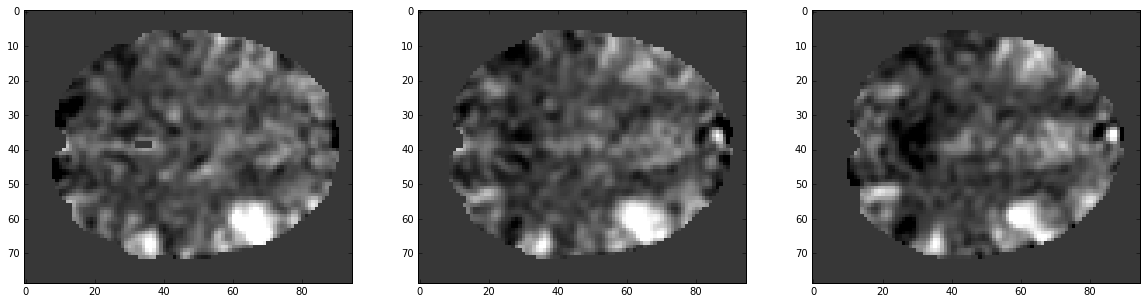

In [14]:
# Take mean of unfixed (OLS) activation pattern across all runs
unfixed_by_run = unfixed_5d.reshape((10 * 2,) + vol_shape)
unfixed_mean = unfixed_by_run.mean(axis=0)
show_slices(unfixed_mean)

This is obvious for some subject runs:

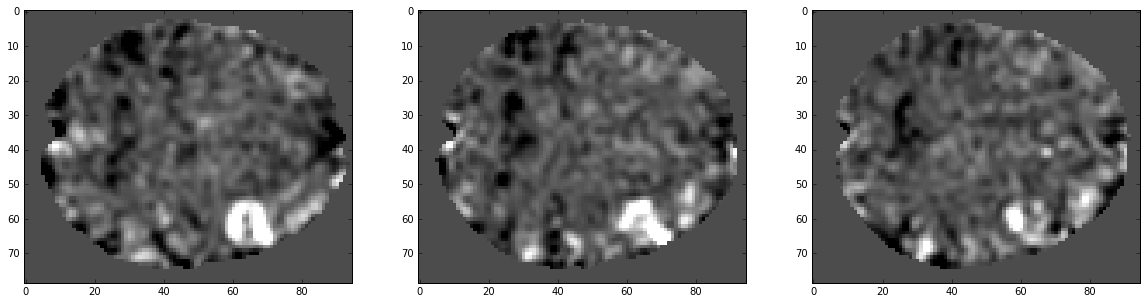

In [15]:
show_slices(models[9][2]['unfixed'])

But not for others:

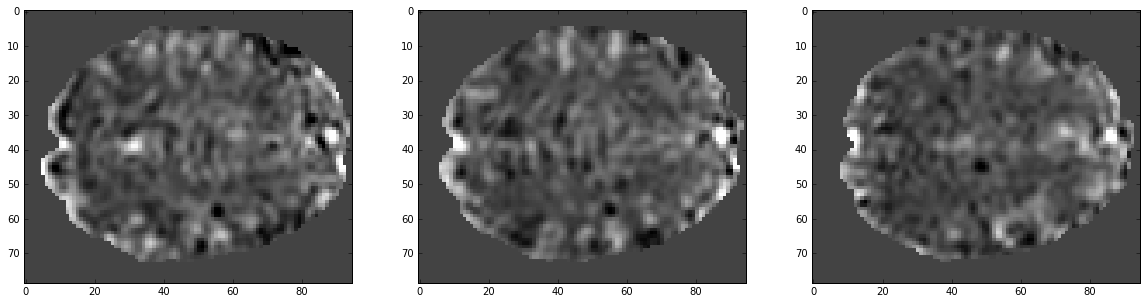

In [16]:
show_slices(models[1][1]['fixed'])

In [17]:
def show_sub_run(all_data, slice_indices=(34, 36, 38)):
    """ Show some slices from a template-shaped volume for all subjects / runs """
    mn, mx = np.percentile(all_data, [0.5, 99.5])
    n_subs, n_runs = all_data.shape[:2]
    fig, axes = plt.subplots(n_subs, n_runs, figsize=(40, 40))
    for sub_i in range(n_subs):
        for run_i in range(n_runs):
            slabs = [rgb_slice(all_data[sub_i, run_i, ..., i], mn, mx) 
                     for i in slice_indices]
            ax = axes[sub_i, run_i]
            ax.imshow(np.hstack(slabs))
            ax.axis('off')

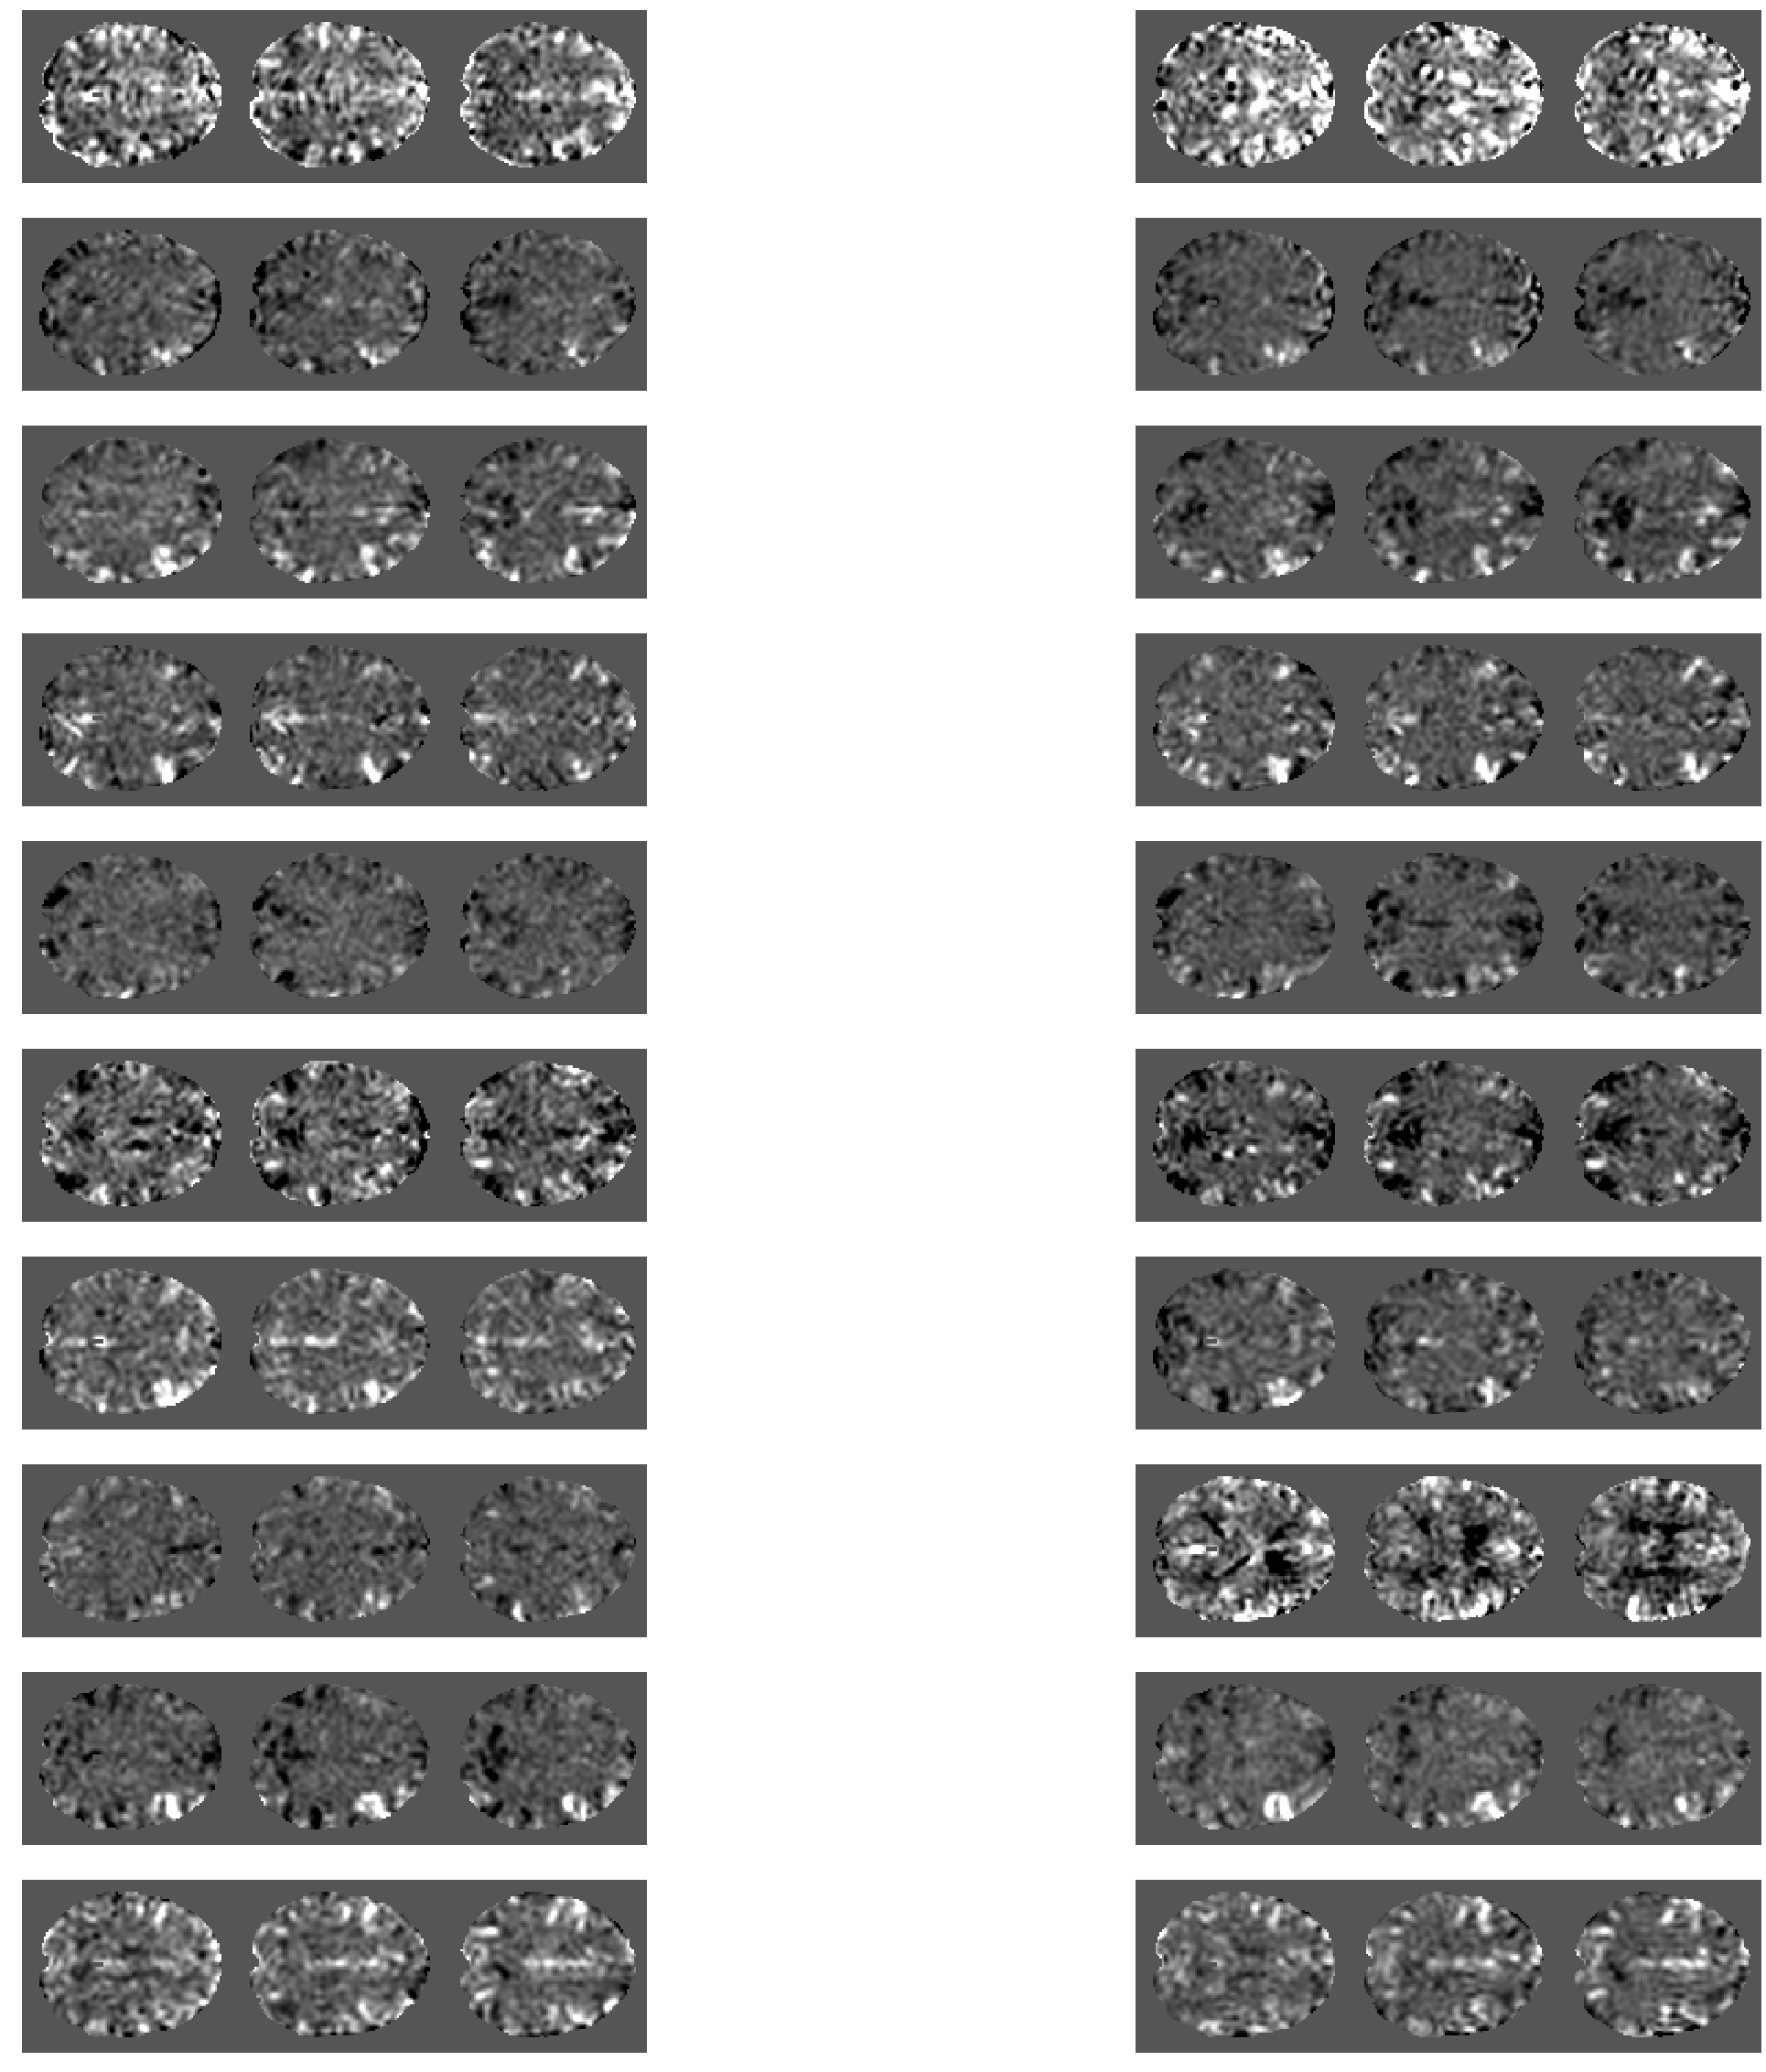

In [18]:
# Show unfixed activation pattern for each subject (row) and each run (column)
show_sub_run(unfixed_5d)

Here is the "fixed" pattern for each subject / run:

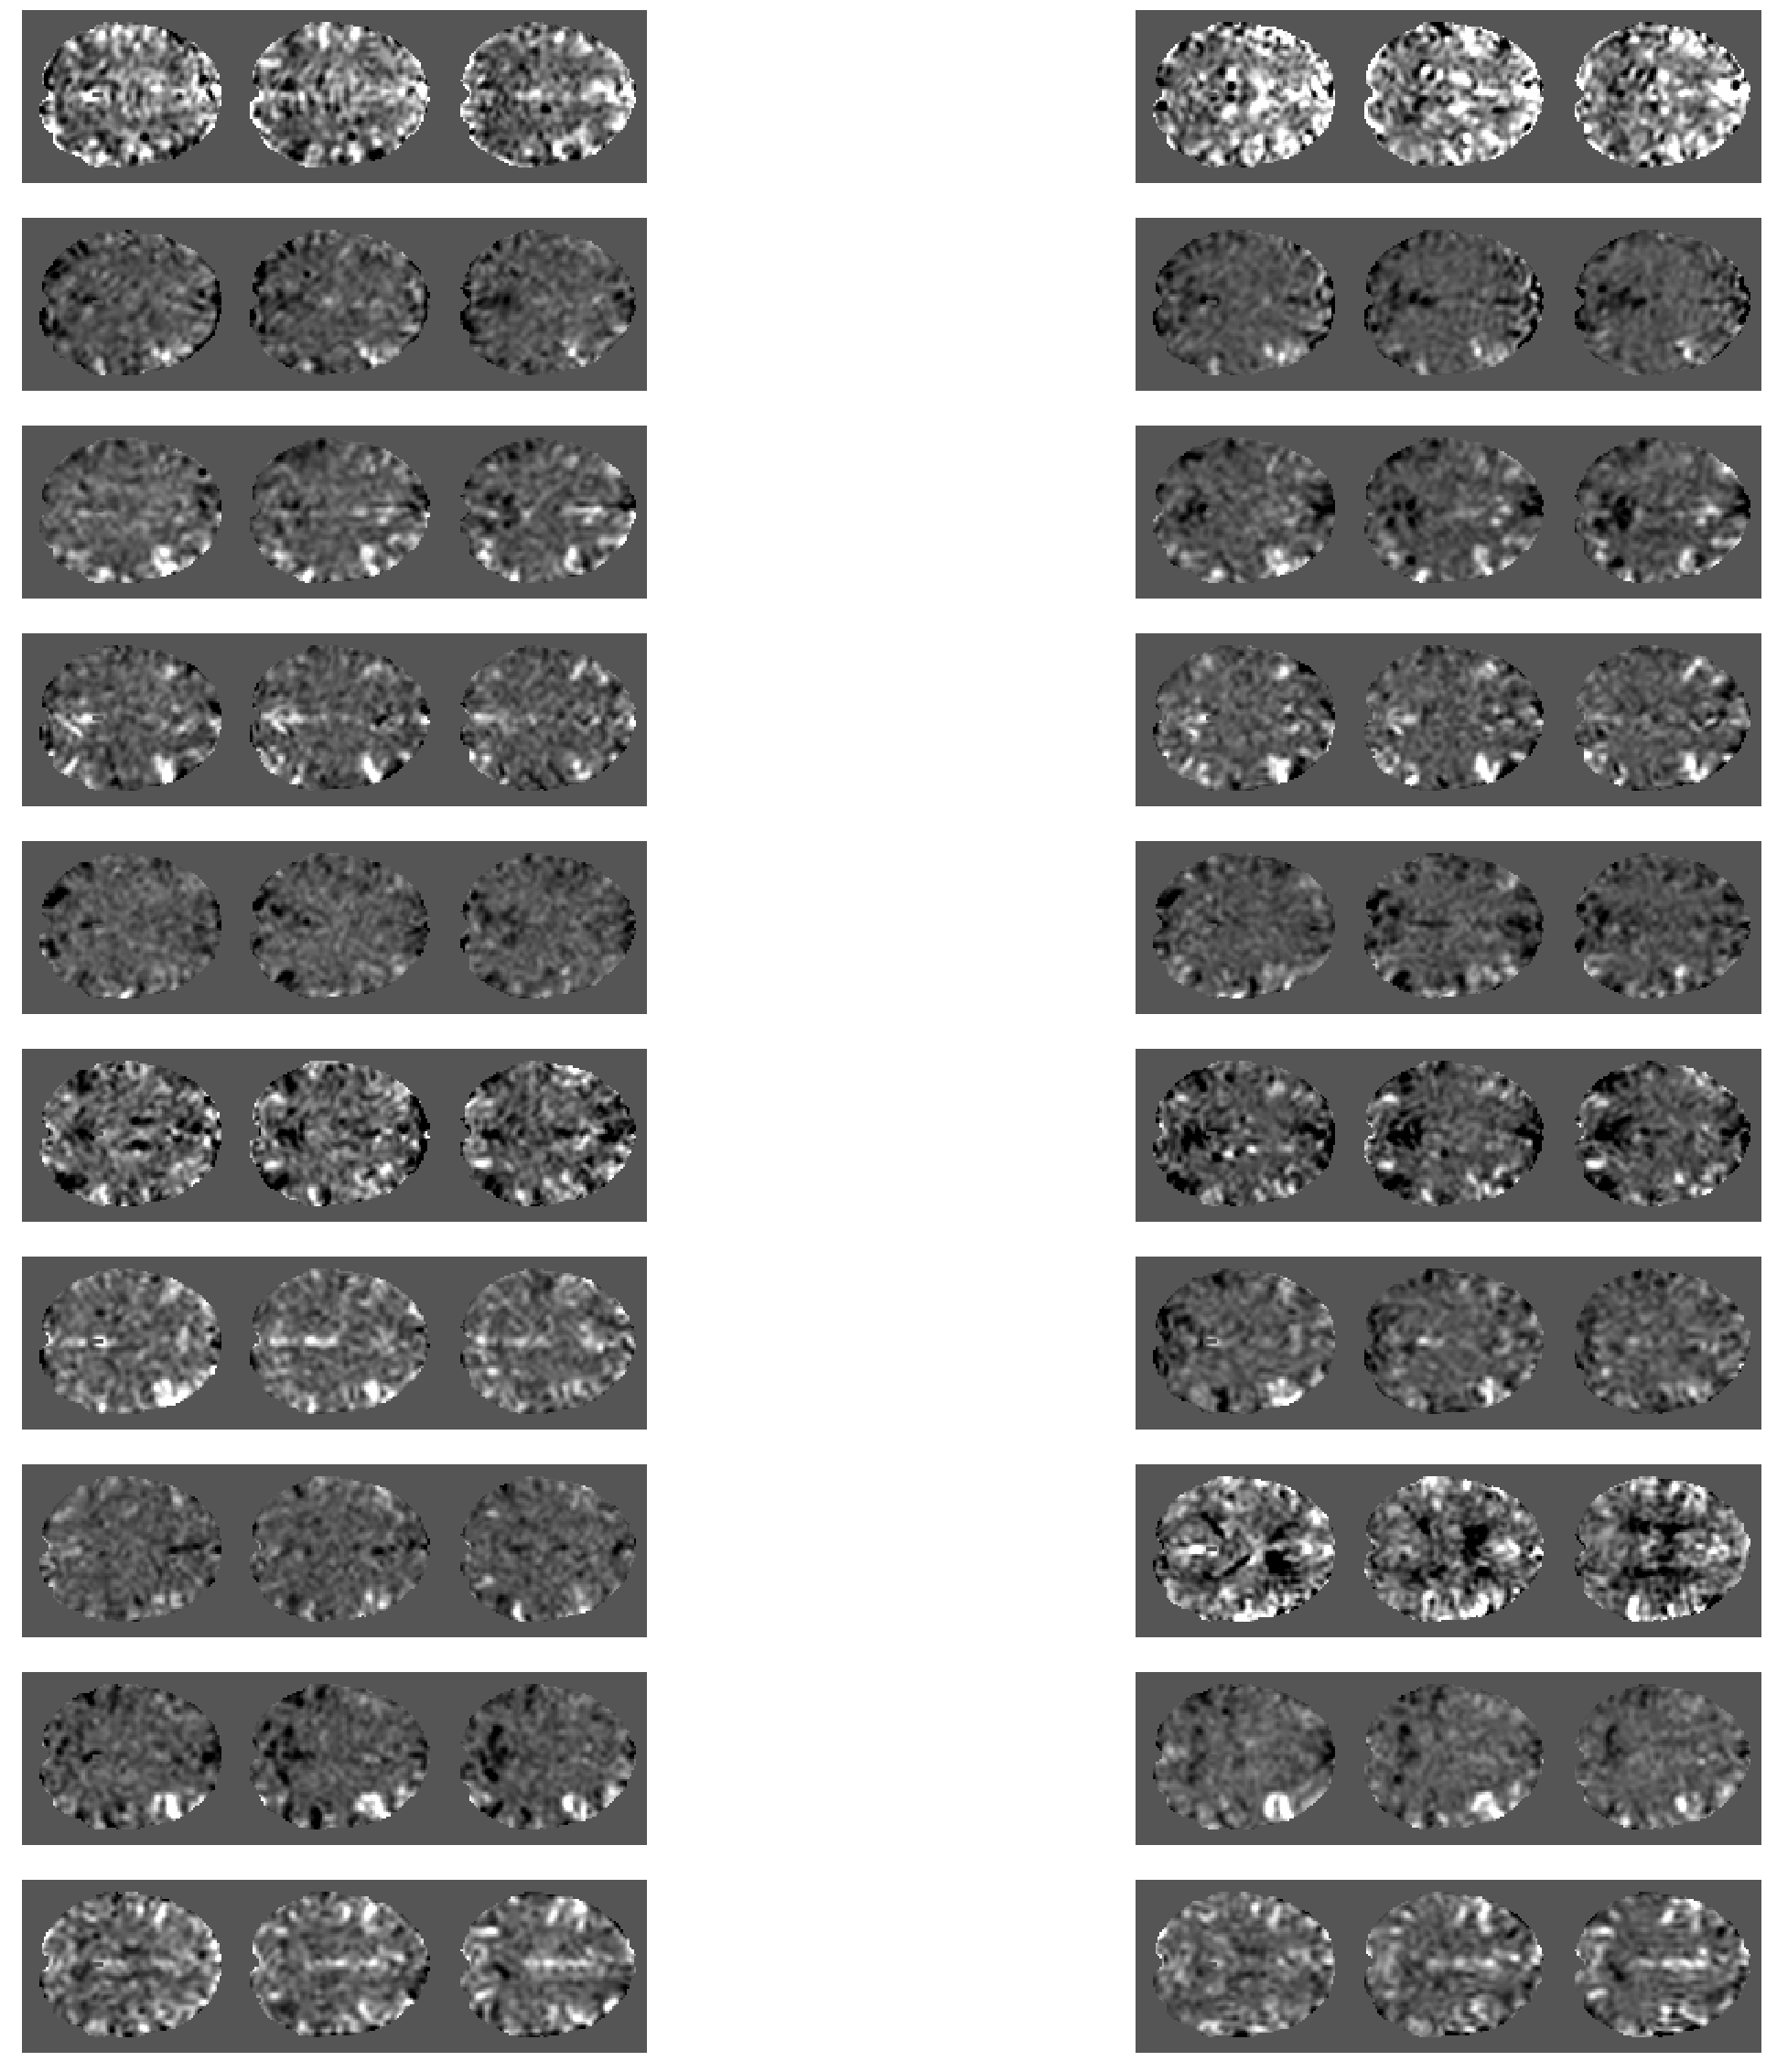

In [19]:
show_sub_run(fixed_5d)

It is difficult to see a difference from these plots.

This is the "unfixed" volume minus the "fixed" volume:

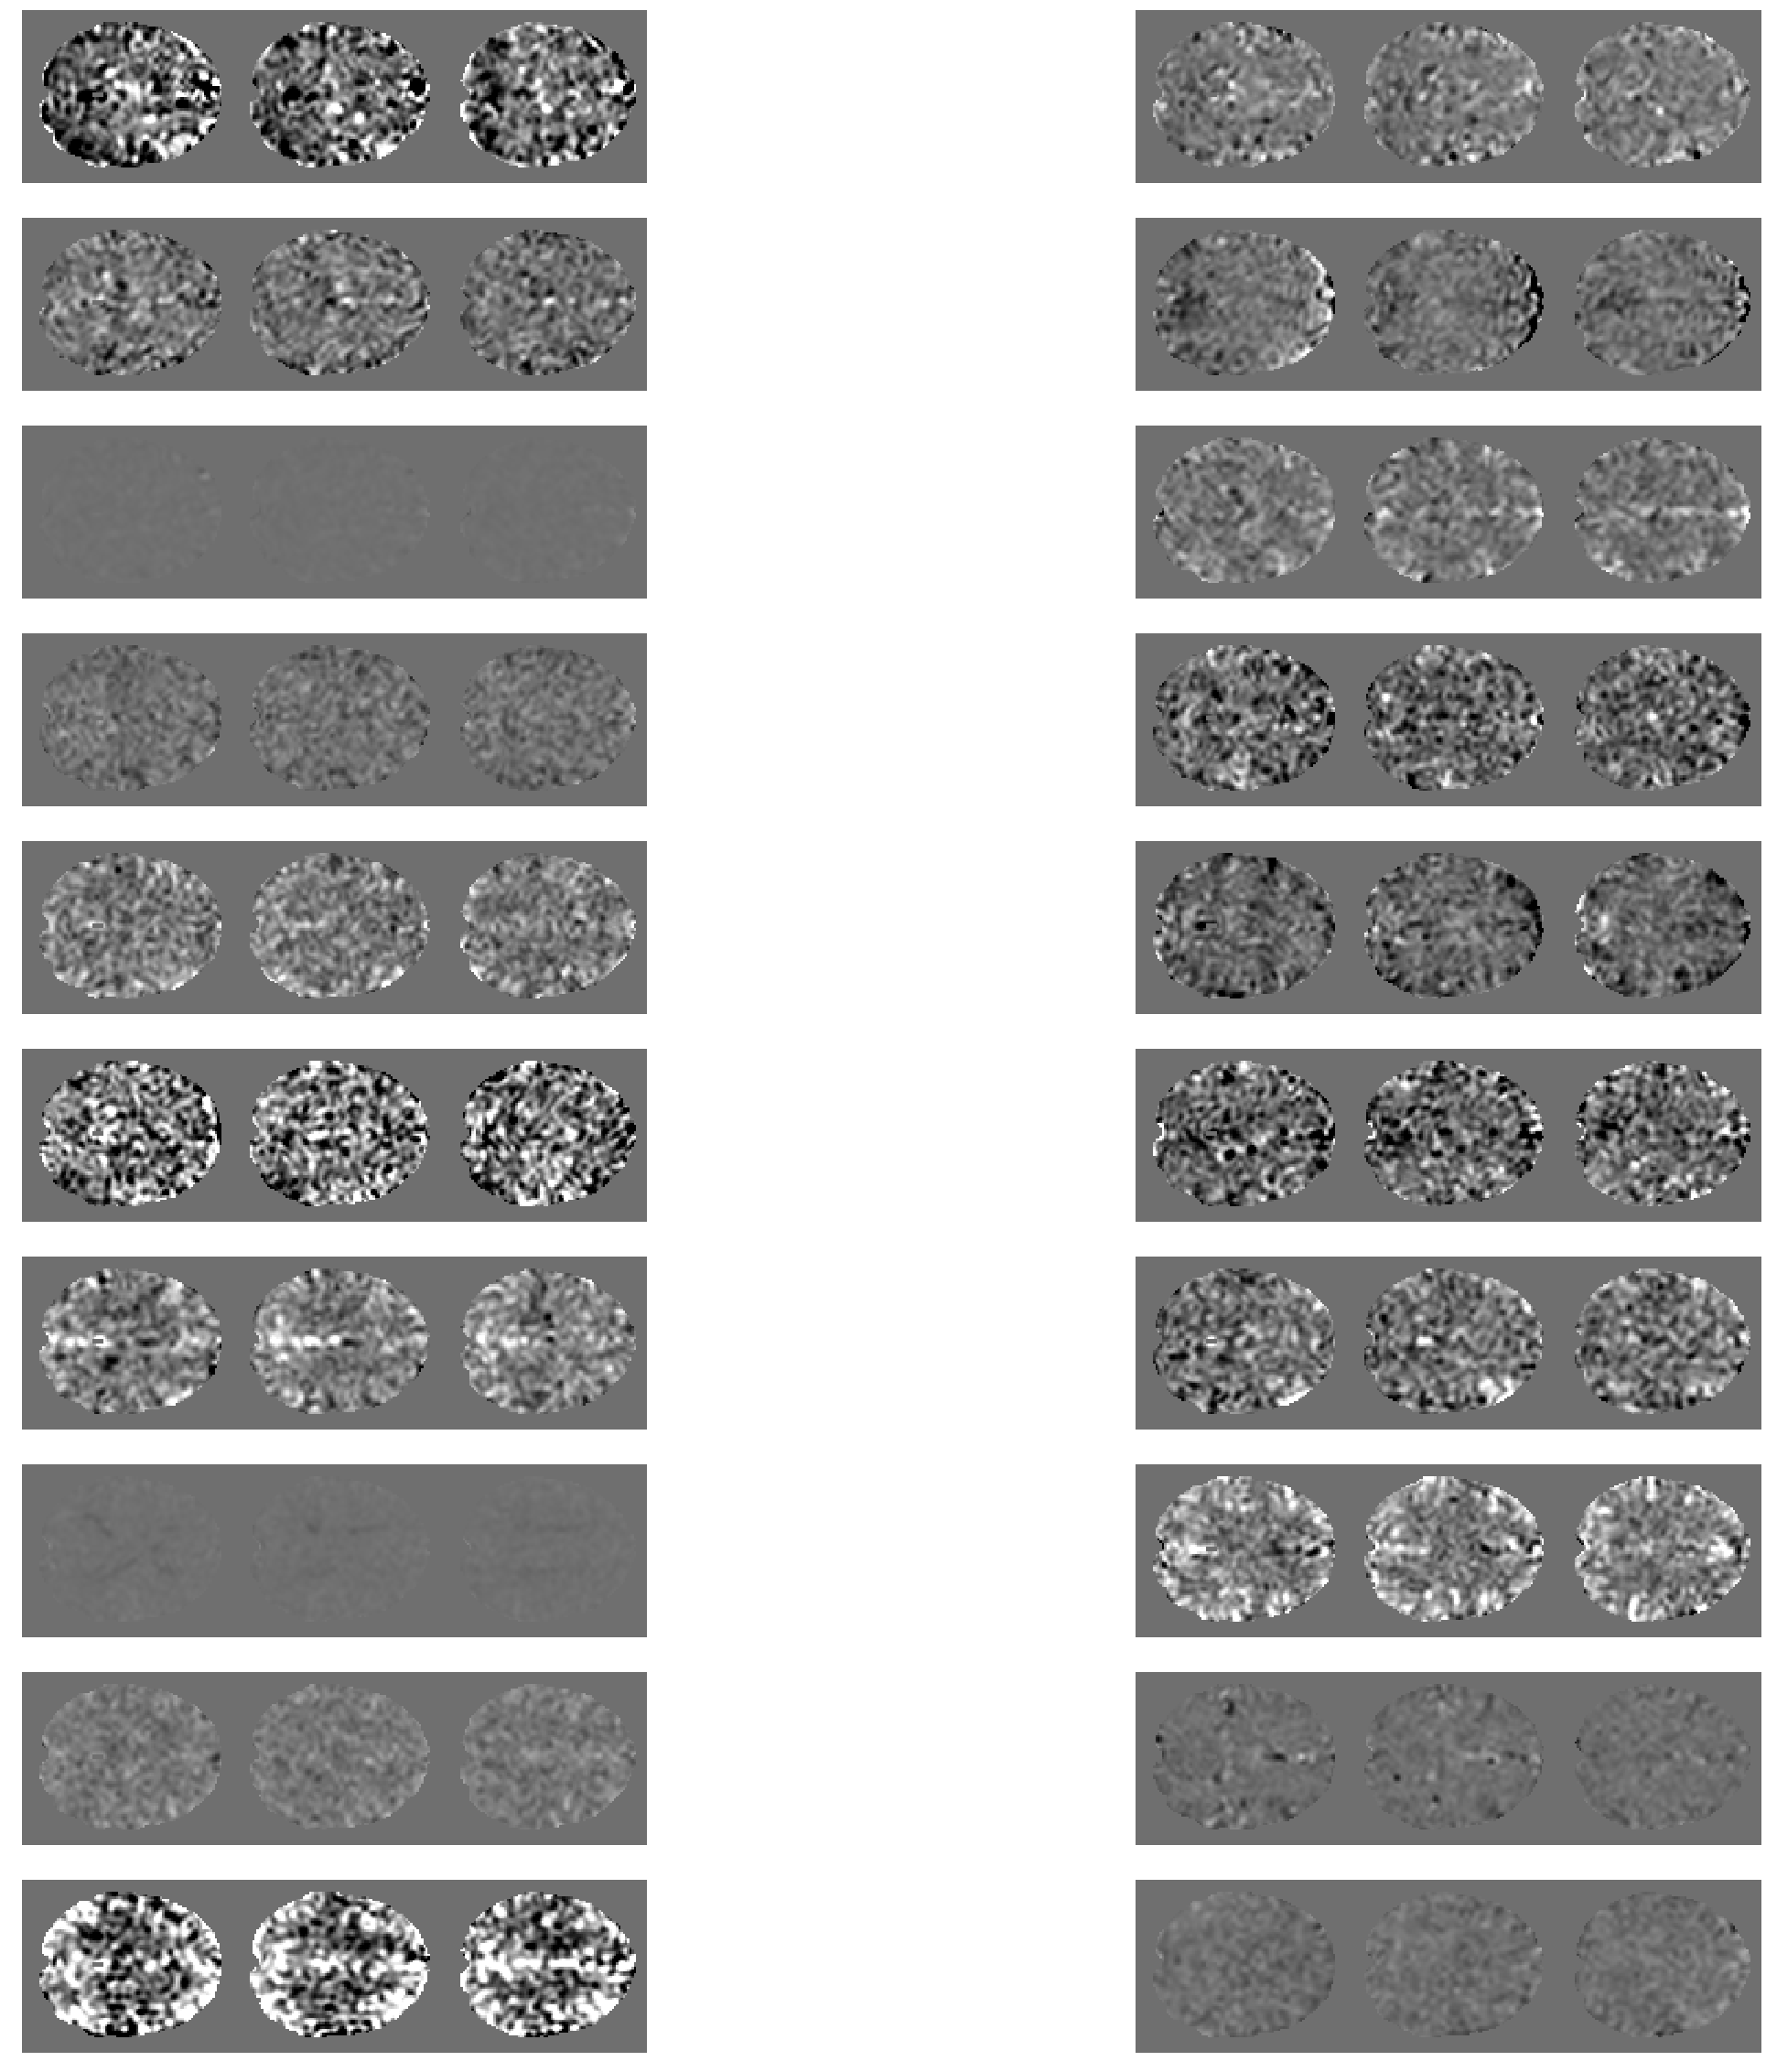

In [20]:
unfixed_fixed = unfixed_5d - fixed_5d
show_sub_run(unfixed_fixed)

The plots are a little encouraging in that they suggest that the noise regressors are picking up some signal that looks like artefact.

## Cross correlation of fixed and unfixed runs

If the noise regression model is reducing signal due to artefacts, then we expect that this signal will not be shared across runs.  Therefore we expect that the "fixed" runs will be a less noisy estimate of the underlying signal.  Assuming the signal is the same across runs, we expect that:

* the "fixed" parameter volumes for the two runs will be more similar to each other than the "unfixed" runs (because they may have removed noise that is not shared across runs).  However, this could also be so if the analyis has a systematic bias that is shared across to thwo runs. 
* the "fixed" parameter volume for the first run will be more similar to the "unfixed" parameter volume for the second run, than is the "unfixed" parameter volume for the first run (and similarly for the second vs first run).  This should not be so if there is bias in the fixed analysis.

I am using the simple correlation coefficient of in-mask voxels as a measure of similarity between the parameter volumes:

In [21]:
# Correlation beteen unfixed parameter volumes for first subject, first run
np.corrcoef(unfixed_5d[0, 0, all_run_mask], unfixed_5d[0, 1, all_run_mask])

array([[ 1.        ,  0.17109953],
       [ 0.17109953,  1.        ]])

In [22]:
# Correlation beteen fixed parameter volumes for first subject, first run
np.corrcoef(fixed_5d[0, 0, all_run_mask], fixed_5d[0, 1, all_run_mask])

array([[ 1.        ,  0.16852774],
       [ 0.16852774,  1.        ]])

In [23]:
# Correlations between fixed, unfixed parameter volumes
intras, extras = ccana.intra_extra_corr(models, all_run_mask)
# First column: correlation of unfixed run 1, 2; 
# Second column; correlation of fixed run 1, 2.
intras

array([[ 0.17109953,  0.16852774],
       [ 0.52895504,  0.53156664],
       [ 0.70412385,  0.70205576],
       [ 0.66125679,  0.66321543],
       [ 0.54624076,  0.54641852],
       [ 0.42152633,  0.42477662],
       [ 0.4418304 ,  0.44065829],
       [ 0.2602273 ,  0.25953391],
       [ 0.64029508,  0.64007717],
       [ 0.70656707,  0.70443677]])

I was expected the second column to have convincingly higher correlations than the first, but this appears not to be the case:

In [24]:
np.mean(np.diff(intras, axis=1))

-8.5531122484389105e-05

In [25]:
# First column : correlation of unfixed run 1, fixed run 2;
# Second column : correlation of unfixed run 2, fixed run 1.
extras

array([[ 0.17042046,  0.1692045 ],
       [ 0.53088282,  0.52962924],
       [ 0.70200259,  0.70417629],
       [ 0.66298533,  0.66149552],
       [ 0.5473218 ,  0.54538526],
       [ 0.42374308,  0.42258973],
       [ 0.43992708,  0.44253166],
       [ 0.25982849,  0.25993179],
       [ 0.64070439,  0.63967214],
       [ 0.70678443,  0.7042176 ]])

I was expecting these correlations to be higher than the first column of `intras`, but this doesn't seem to be so either:

In [26]:
np.mean(extras - intras[:, 0][:, None])

-4.050493578059283e-05

## Questions

* Is the choice of noise design matrix reasonable?  Or will the similarity between columns cause poor estimation?
* The lagrange parameter is obviously completely ad-hoc just to get going.  Can you suggest a more principled way to choose it?
* Do you think that the correlation metric is a reasonable one to detect reduction of noise in the analysis?